<figure>
  <IMG SRC="https://raw.githubusercontent.com/fmeer/public-files/main/TUlogo.png" WIDTH=200 ALIGN="right">
</figure>

# Supervised Machine Learning for Regression - Regularization and Stochastic Gradient Descent

In [ ]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mude_tools import magicplotter
%matplotlib widget

## Introduction

As the previous notebook shows, the least squares approach can lead to severe over-fitting if complex models are trained on small datasets. Our strategy of limiting the number of basis functions a priori to counter overfitting puts us at risk of missing critical trends in the data. Another way to control model flexibility is by introducing a regularization term. This additional term essentially puts a penalty on the weights and prevents them from taking too large values unless supported by the data. The concept of regularized least squares will be demonstrated on the usual sine function.

In [ ]:
np.random.seed(1)

# The true function relating t to x
def f_truth(x, freq=1, **kwargs):
    
    # Return a sine with a frequency of f
    return np.sin(x * freq)

# The data generation function
def f_data(epsilon=0.5, N=20, **kwargs):

    # Apply a seed if one is given
    if 'seed' in kwargs:
        np.random.seed(kwargs['seed'])

    # Get the minimum and maximum
    xmin = kwargs.get('xmin', 0)
    xmax = kwargs.get('xmax', 2*np.pi)
    
    # Generate N evenly spaced observation locations
    x = np.linspace(xmin, xmax, N)
    
    # Generate N noisy observations (1 at each location)
    t = f_truth(x, **kwargs) + np.random.normal(0, epsilon, N)
    
    # Return both the locations and the observations
    return x, t

# Get the observed data
x, t = f_data()
x_pred = np.linspace(0, 2*np.pi, 1000)

# Plot the data and the ground truth
fig, ax = plt.subplots(figsize=(8,4.5))
ax.set_position([0.2,0.1, 0.7, 0.8])
plt.plot(x_pred, f_truth(x_pred), 'k-', label=r'Ground truth $f(x)$')
plt.plot(x, t, 'x', label=r'Noisy data $(x,t)$')
plt.xlabel('x')
plt.ylabel('t')
plt.legend()

plt.show()
# plt.canvas.draw_idle()

## Regularized least squares

We extend the data-dependent error $E_D(\bf{w})$ with the regularization term $E_W(\bf{w})$:

$$
E (\mathbf{w}) = E_D (\mathbf{w}) + \lambda E_W (\mathbf{w})
$$

with regularization parameter $\lambda$ that controls the relative importance of two terms comprising the error function. A common choice for the regularizer is the sum-of-squares:

$$
E_W(\mathbf{w}) = \frac{1}{2} \mathbf{w}^T \mathbf{w}.
$$

The resulting model is known as L2 regularization, ridge regression, or weight decay. The total error therefore becomes

$$
E (\mathbf{w}) = \frac{1}{2} \sum_{n = 1}^{N} \left( t_n - \mathbf{w}^T \boldsymbol{\phi} (x_n) \right)^2 + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}.
$$

<!-- Taking its gradient gives

$$
\nabla_{\mathbf{w}} E_{\mathcal{D}} = \frac{1}{N} \sum_{n=1}^N \big(t_n - \mathbf{w}^T \mathbf{x}_n \big) \mathbf{x}_n
$$ -->

A useful property of the L2 regularization is that the error functions is still a quadratic function of $\mathbf{w}$, allowing for a closed form solution for its minimizer. Setting the gradient of the regularized error function with respect to $\mathbf{w}$ to $0$ gives

$$
\bar{\mathbf{w}} = \big( \boldsymbol{\Phi}^T \boldsymbol{\Phi} + \lambda \mathbf{I} \big)^{-1} \boldsymbol{\Phi}^T \mathbf{t}.
$$

<!-- Keeping in mind that $\boldsymbol{\Phi}^T \boldsymbol{\Phi}$ is a positive semi-definite matrix, the eigenvalues of the inverse of $\boldsymbol{\Phi}^T \boldsymbol{\Phi} + \lambda \mathbf{I}$ will shrink with an inceasing $\lambda$, therefore pulling the weights towards $0$ compared to the unregularized solution. -->

## Determining the regularization parameter

The `predict` function in the code below has been adapted to include this regularization term.

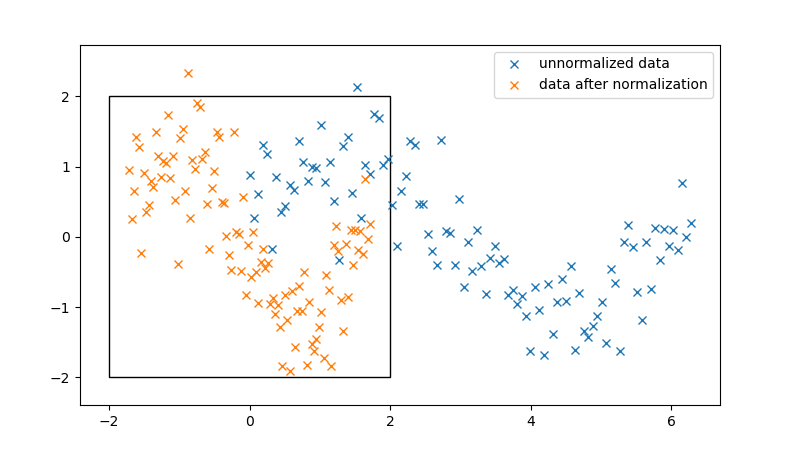

In [3]:
# generate data, instantiate scaler, and fit tranform
np.random.seed(0)
x, t = f_data(N=100)
xscaler, tscaler = StandardScaler(), StandardScaler()
x_norm, t_norm = xscaler.fit_transform(x[:,None]), tscaler.fit_transform(t[:,None])

# plot
fig, ax = plt.subplots(figsize=(8,4.5))
ax.set_position([0.1,0.1, 0.8, 0.8])
ax.plot(x,t,'x', label='unnormalized data')
ax.plot(x_norm,t_norm,'x', label='data after normalization')

# Create a Rectangle patch
rect = patches.Rectangle((-2, -2), 4, 4, linewidth=1., edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
ax.set_aspect('equal', 'datalim')

plt.legend(loc='upper right')

plt.show()

In [ ]:
# Here is a function for the RadialBasisFunctions:
def RadialBasisFunctions(x, M_radial, l_radial, **kwargs):
    """
    A function that computes radial basis functions.
    
    Arguments:
    X        -  The centers of the radial basis functions.
    M_radial -  The number of basis functions
    l_radial -  The width of each basis function
    """
    
    mu = np.linspace(-2, 2, M_radial)
    num_basis = mu.shape[0]

    Phi = np.ndarray((x.shape[0], num_basis))
    for i in range(num_basis):
        Phi[:,i] = np.exp(-.5 * (x - mu[i]) ** 2 / l_radial ** 2)
    return Phi

In [ ]:
# Define a function that makes a prediction at the given locations, based on the given (x,t) data
def predict(x, t, x_pred, basis, lam=None, **kwargs):
    
    # reshape if necessary for scalers
    x = x[:,None] if len(x.shape)==1 else x
    t = t[:,None] if len(t.shape)==1 else t
    x_pred = x_pred[:,None] if len(x_pred.shape)==1 else x_pred
    
    # normalize data
    xscaler, tscaler = StandardScaler(), StandardScaler()
    x_sc, t_sc = xscaler.fit_transform(x), tscaler.fit_transform(t)
    
    # if 'M_radial' in kwargs:
    #     Phi = basis (x_sc.reshape(-1), kwargs['M_radial'], kwargs['l_radial'], **kwargs)
    # else:
    Phi = basis(x_sc.reshape(-1), **kwargs)
    
    # Get the variable matrix using the basis function phi
    t_sc = t_sc.reshape(-1)
    x_pred = xscaler.transform(x_pred).reshape(-1)
    
    # Get identity matrix, set first entry to 0 to neglect bias in regularizaiton
    I = np.identity(Phi.shape[1])
    I[0,0] = 0.0
    
    # Get the coefficient vector
    if lam is None:
        w = np.linalg.solve( Phi.T @ Phi , Phi.T @ t_sc )
    else:
        w = np.linalg.solve( Phi.T @ Phi + lam * I, Phi.T @ t_sc )
    
    # Make a prediction in the prediction locations
    Phi_pred = basis(x_pred, **kwargs)
    t_pred = Phi_pred @ w
    
    # Return the predicted values
    return tscaler.inverse_transform(t_pred[:,None]).reshape(-1)

In [ ]:
# # Let's try out our ridge regression model
x_plot = np.linspace(0, 2*np.pi, 1000)[:,None]

# set seed and generate data
np.random.seed(0)
M_radial = 10
l_radial = 0.5
x_train, t_train = f_data(N=15)

# Let's take a look at our regularized solution
plot = magicplotter(f_data, f_truth, predict, x_plot, x_train, t_train,
                    basis=RadialBasisFunctions, M_radial=M_radial, l_radial=l_radial, lam=1e-12,
                    pred_label='Prediction $y(x)$', height=4.5)
plot.show()

You can play around with the number of radial basis functions and the regularization parameter. Try to answer the following questions:

- What happens for a low number of RBF, and what happens for a number thereof?

- How does this affect the value of $\lambda$ that yields the (visually) best fit?

- How does a larger dataset affect the optimal regularization parameter $\bar{\lambda}$?


The pressing question is, of course: **how do we determine $\lambda$?** 

The problem of controlling model complexity has been shifted from choosing a suitable set of basis functions to determining the regularization parameter $\lambda$. **Optimizing for both $\mathbf{w}$ and $\lambda$ over the training dataset will always favor flexibility, leading to the trivial solution $\lambda = 0$** and, therefore, to the unregularized least squares problem. Instead, similar to what we did in notebook 2, the data should be partitioned into a training set and a validation set. The training set is used to determine the parameters $\mathbf{w}$, and the validation set to optimize the model complexity through $\lambda$. 

In the block below we use a pragmatic approach and sample another dense validation set from our ground truth instead of splitting the original training dataset. We then loop over several values of $\lambda$ until we find the one corresponding to the minimum validation error. This is then our selected model.

In [ ]:
# set seed and generate data
np.random.seed(4)
x_train, t_train = f_data(N=15)
x_val, t_val = f_data(N=500)

# set up some vectores and params for the training
lams    = np.logspace(-10,20,100,base=np.exp(1))
mse_val = np.zeros_like(lams)
x_plot  = np.linspace(0, 2*np.pi, 1000)[:,None]

M_radial = 10
l_radial = 0.5

# loop over all lambdas 
for i, lam in enumerate(lams):
    t_pred = predict(x_train, t_train, x_val, RadialBasisFunctions, M_radial=M_radial, l_radial=l_radial, lam=lam)
    mse_val[i] = sum((t_val - t_pred)**2) / len(x_val)

# find lambda with minimum mse
loc = np.argmin(mse_val)
lam_min = lams[loc]
mse_min = mse_val[loc]
print("Best fit for lambda = {:e}  with MSE = {:4f}".format(lam_min, mse_min))
    
# plot mse over ln(lambda)
fig, ax = plt.subplots(figsize=(8,4.5))
ax.set_position([0.2,0.1, 0.7, 0.8])
# fig, ax = plt.subplots(figsize=(6,4))
ax.plot(lams, mse_val)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'MSE')
ax.set_xscale('log')
plt.show()

We then take a look at how the optimally regularized model looks like:

In [ ]:
# Let's take a look at our regularized solution
plot = magicplotter(f_data, f_truth, predict, x_plot, x_train, t_train,
                    basis=RadialBasisFunctions, M_radial=M_radial, l_radial=l_radial,  lam=lam_min,
                    pred_label='Prediction $y(x)$',  height=4.5)

That looks much better than the solution of the unregularized problem, which you can obtain by removing $\lambda$ from arguments when calling the `predict` function. Luckily, this problem has a unique solution $\bar{\lambda}$. Can you explain why the error first decreases but keeps growing again at some point? Do you always expect this non-monotonic characteristic when looking at the **training** error as a function of the regularization parameter?

## Stochastic Gradient Descent (SGD)

For now, we used the same dataset at once. In some situations, it might be beneficial or necessary to look at only a part of the dataset, e.g., when

- $N$ is too large and computing $( \boldsymbol{\Phi}^T \boldsymbol{\Phi} )^{-1}$ becomes prohibitively expensive
- the model is nonlinear in $\mathbf{w}$, and $\mathbf{w}_\mathrm{ML}$ does not have a closed-form solution
- the dataset is arriving sequentially (e.g., in real-time from a sensor)

Instead of solving for $\mathbf{w}$ directly, we could employ an iterative optimization strategy. Let's first take a look at the data part of the error function, and its gradient with respect to $\mathbf{w}$:

$$
E_D = \frac{1}{2N} \sum_{n = 1}^{N} \left( t_n - \mathbf{w}^T \boldsymbol{\phi}_n \right)^2 \quad \mathrm{with \, gradient} \quad \nabla E_D = - \frac{1}{N} \sum_{n=1}^N \big(t_n - \mathbf{w}^T \boldsymbol{\phi}_n \big) \boldsymbol{\phi}_n.
$$

The standard formulation does not include the division by the dataset size, the stepsize is purely regulated through the learning rate. However, normalizing the gradient with $N$ makes the influence of the learning rate more consistent when considering different datasets. With a standard gradient descent algorithm, the update rule for the weights is given by

$$
\mathbf{w}^{(\tau + 1)} = \mathbf{w}^{(\tau)} - \eta \nabla E_D
$$

with a fixed *learning rate* $\eta$. The costs for the gradient computations are independent of the dataset size $N$, when only considering subset $\mathcal{B}$ of our dataset with $N_{\mathcal{B}}$ data points. If we pick a random subset $\mathcal{B}$ for each iteration of the optimization scheme, we have derived the *stochastic gradient descent* algorithm. Together with its numerous variants, this algorithm forms the backbone of many machine learning techniques. Most deep learning libraries, such as `TensorFlow` or `PyTorch` offer implementations of these algorithms.

We looked at the unregularized model to introduce SGD, but the extension to the regularized model is straightforward. Remember, in this case, the objective function is given by

$$
E (\mathbf{w}) = \frac{1}{2N} \sum_{n = 1}^{N} \left( t_n - \mathbf{w}^T \boldsymbol{\phi}_n \right)^2 + \frac{\lambda}{2N} \mathbf{w}^T \mathbf{w},
$$

and its gradient with respect to $\mathbf{w}$ reads

$$
\nabla E = \frac{1}{N} \left( - \sum_{n=1}^N \big(t_n - \mathbf{w}^T \boldsymbol{\phi}_n \big) \boldsymbol{\phi}_n + \lambda \, \mathbf{w} \right).
$$

When looking at the expresssion in the outer bracket, it becomes clear there are **two competing terms**: the first term pulls the weights towards the data, and the second term pulls them towards zero. Looking at the gradient, you can also see why ridge regression often is referred to as weight decay. The larger the weights become, the stronger the regularization term pulls them towards zero. If the data would not support a value for a certain weight, its presence in the gradient will lead to the weight decaying at a rate proportional to its magnitude.

In [ ]:
# This function returns the gradient of the cost function
def get_gradient(x, t, w, basis, lam=0., **kwargs):
    
    # Get the variable matrix using the basis function phi
    Phi = basis(x.reshape(-1), **kwargs)
    t = t.reshape(-1)
    
    return (- ( t - w @ Phi.T ) @ Phi + lam * w ) / len(t)

In [1]:
# set parameters
N, N_train = 500, 20
M_radial = 50                       # number of radial basis functions  
l_radial = 0.20                     # lenghtscale of radial basis functions
eta = 0.01                          # learning rate
epochs = 1000                       # number of epochs
N_batch = 5                         # size of the minibatch B
lam = np.exp(0.05)                  # Regularization parameter

# select where to plot solution
epoch_plot_marks = np.logspace(np.log10(5),np.log10(epochs), 10, dtype=int)

# randomly init weights
np.random.seed(6)
w = (np.random.rand(M_radial) - 0.5) / M_radial
w_reg = w.copy()

# get colormap
rgb = cm.get_cmap('summer')(np.linspace(0,1,10))[:, :3]

# generate, scale, and partition data
x, t = f_data(N= N + N_train)
x_plot = np.linspace(0,2*np.pi,100)
xscaler, tscaler = StandardScaler(), StandardScaler()
x_sc, t_sc = xscaler.fit_transform(x[:,None]), tscaler.fit_transform(t[:,None])
x_train, x_val, t_train, t_val = train_test_split(x_sc, t_sc, train_size=N_train)
x_train, x_val, t_train, t_val = x_train.reshape(-1), x_val.reshape(-1), t_train.reshape(-1), t_val.reshape(-1)

# get features
Phi_plot  = RadialBasisFunctions(xscaler.transform(x_plot[:,None]).reshape(-1), M_radial=M_radial, l_radial=l_radial)
Phi_train = RadialBasisFunctions(x_train, M_radial=M_radial, l_radial=l_radial)
Phi_val   = RadialBasisFunctions(x_val, M_radial=M_radial, l_radial=l_radial)

# create figure
fig, ax = plt.subplots(2, 2, figsize=(13,8), sharey='row')
plt.subplots_adjust(wspace=0.1)
ax[0,0].plot(xscaler.inverse_transform(x_train[:,None]), tscaler.inverse_transform(t_train[:,None]), 'x')
ax[0,1].plot(xscaler.inverse_transform(x_train[:,None]), tscaler.inverse_transform(t_train[:,None]), 'x')
ax[0,0].plot(x_plot, f_truth(x_plot), 'k-'), ax[0,1].plot(x_plot, f_truth(x_plot), 'k-')
ax[0,0].set_xlabel('x'), ax[0,1].set_xlabel('x'), ax[0,0].set_ylabel('t')
ax[1,0].set_xlabel('epochs'), ax[1,1].set_xlabel('epochs'), ax[1,0].set_ylabel('RMSE')
ax[0,0].set_ylim(-2,2), ax[0,1].set_ylim(-2,2)
ax[0,0].set_title("Unregularized"), ax[0,1].set_title("Regularized")

# init rmse
rmse_train, rmse_train_reg = np.zeros(epochs), np.zeros(epochs)
rmse_val, rmse_val_reg = np.zeros(epochs), np.zeros(epochs)

# loop over epochs
for i in range(epochs):
    perm = np.random.permutation(N_train)
    
    # loop over batches
    for j in range(int(N_train/N_batch)):
        x_batch  = x_train[perm[j*N_batch:(j+1)*N_batch]]
        t_batch  = t_train[perm[j*N_batch:(j+1)*N_batch]]
        dEdw     = get_gradient(x_batch, t_batch, w, RadialBasisFunctions, M_radial=M_radial, l_radial=l_radial)
        dEdw_reg = get_gradient(x_batch, t_batch, w_reg, RadialBasisFunctions, lam=lam, M_radial=M_radial, l_radial=l_radial)
        w        = w - eta * dEdw
        w_reg    = w_reg - eta * dEdw_reg
        
    # get predictions
    t_pred_train     = w     @ Phi_train.T
    t_pred_train_reg = w_reg @ Phi_train.T
    t_pred_val       = w     @ Phi_val.T
    t_pred_val_reg   = w_reg @ Phi_val.T
    
    # compute rmse
    rmse_train[i]     = np.sqrt(sum((tscaler.inverse_transform(t_train[:,None])
                                     - tscaler.inverse_transform(t_pred_train[:,None]))**2) / len(t_train))
    rmse_train_reg[i] = np.sqrt(sum((tscaler.inverse_transform(t_train[:,None])
                                     - tscaler.inverse_transform(t_pred_train_reg[:,None]))**2) / len(t_train))
    rmse_val[i]       = np.sqrt(sum((tscaler.inverse_transform(t_val[:,None])
                                     - tscaler.inverse_transform(t_pred_val[:,None]))**2) / len(t_val))
    rmse_val_reg[i]   = np.sqrt(sum((tscaler.inverse_transform(t_val[:,None])
                                     - tscaler.inverse_transform(t_pred_val_reg[:,None]))**2) / len(t_val))
    
    # plot some of the iterations to see progression of our model
    if (i+1) in epoch_plot_marks:
        t_plot     = w     @ Phi_plot.T
        t_plot_reg = w_reg @ Phi_plot.T
        ax[0,0].plot(x_plot, tscaler.inverse_transform(t_plot[:,None]).reshape(-1),
                     color=rgb[int(i/epoch_plot),:], label=r'{}'.format(i+1))
        ax[0,1].plot(x_plot, tscaler.inverse_transform(t_plot_reg[:,None]).reshape(-1),
                     color=rgb[int(i/epoch_plot),:], label=r'{}'.format(i+1))

# put legend
ax[0,0].legend(loc='lower left', ncol=2)
ax[0,0].get_legend().set_title(r'epochs')

# plot rmse
ax[1,0].semilogx(np.arange(1,epochs+1), rmse_train, label=r'$RMSE_{train}$')
ax[1,0].semilogx(np.arange(1,epochs+1), rmse_val, label=r'$RMSE_{val}$')

ax[1,1].semilogx(np.arange(1,epochs+1), rmse_train_reg, label=r'$RMSE_{train}$')
ax[1,1].semilogx(np.arange(1,epochs+1), rmse_val_reg, label=r'$RMSE_{val}$')
ax[1,0].legend(), ax[1,1].legend()

plt.show()


NameError: name 'np' is not defined

You can see in the top figure that our predictions seem to converge towards a particular shape. The remaining discrepancy between our final model and the true function $f$ is due to our general model bias, and the particular dataset we drew. What happens if you increase the number of basis functions? Can you explain why we do not approach the target function?

You can see that our validation error increases at some point, indicating that overfitting might occur. Again, note how the training error cannot feel that, and just decreases monotonically. SGD with minibatches already has a slight regularizing effect. Other remedies include the L2-regularization technique discussed discusses previously, early stopping, or collecting more data. Try to see how the RMSE for the training and validation set will behave for larger datasets by adapting the training dataset size `N_train`.

Finally, it should be noted that the step size of the SGD must be chosen carefully. Try out for yourself what happens when you choose very small or large stepsizes by adapting the learning rate `eta`. Even though this optimization problem is well-defined and has a global minimum, SGD is not guaranteed to converge to it. Luckily, the most popular variants such as [AdaGrad][1], [RMSProp][2], and [Adam][3] feature some form of adaptive stepsize control, improving convergence rate and robustness. One usually starts with a larger stepsize to approach the minimum quickly. After that, the stepsize is reduced continuously to reliably uncover the exact location of the extremum.

[1]: https://jmlr.org/papers/volume12/duchi11a/duchi11a.pdf
[2]: http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf
[3]: https://arxiv.org/abs/1412.6980